In [1]:

#%matplotlib inline 

###########
#PDF PROCESSING FOR various INPUT 
# DEPENDING ON THE PDF_PROCESSING CLASS
#by Carl Schleussner, Climate Analytics
#carl.schleussner@climateanalytics.org
###########

# IMPORT AND CONFIG 
import numpy as np
import netCDF4 as net
import dimarray as da 
import sys,glob,datetime,pickle,os,itertools
import pandas as pd
import matplotlib.pylab as plt 
from netCDF4 import Dataset,netcdftime,num2date

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 8,6
from matplotlib import rc
rc('text', usetex=True)

os.chdir('/Users/peterpfleiderer/Documents/Projects/0p5_observed/pdf_processing/')
try:
    import pdf_processing as pdf; reload(pdf)
except ImportError:
    raise ImportError(
        "cannot find PDF_Processing code")

###########
# Settings
###########

# PDF Method (currently defined: hist, python_silverman)
pdf_method='python_silverman'

# variables
varin_dict={
    'TXx':{'var_name':'TXX','longname':'Hot extremes (TXx)','unit':'TXx [$^\circ$ C]'},
    'TNn':{'var_name':'TNN','longname':'Cold extremes (TNn)','unit':'TNn [$^\circ$ C]'},
    'WSDI':{'var_name':'WSDI','longname':'Warm-spell duration (WSDI)','unit':'WSDI [days]'},
    'RX5':{'var_name' :'Rx5day','longname':'5-day heavy rainfall (Rx5day)','unit':'RX5 [$\%$]'},
    'RX1':{'var_name':'Rx1day','longname':'Daily heavy rainfall (Rx1day)', 'unit':'RX1 [$\%$]'}}

# time informations and periods
timeaxis=np.arange(1958,2011)
ref_period=[1960,1979]
target_periods=[[1991,2010],ref_period]
period_names=['Recent','ref']

# Set range for years for bootstrap sampling 
bs_range=[1958,2010]

# Input datasets
datasets=['HadEX2','GHCNDEX']

varoutdict={
    datasets[0]:{},    
    datasets[1]:{},    
}

# Set plottint colours
colordict={
    datasets[0]:"#247a9c",
    datasets[1]:"#df1a20",
}

In [7]:
##############
# HadEx2 & GHCND
##############

for varin in varin_dict.keys():
    for dataset in ['HadEX2','GHCNDEX']:
        print varin,dataset
        if dataset =='HadEX2':
            read_in_data=da.read_nc('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/HadEx2/H2_'+varin_dict[varin]['var_name']+'_1901-2010_RegularGrid_global_3.75x2.5deg_LSmask.nc')['Ann']
        elif dataset =='GHCNDEX':
            read_in_data=da.read_nc('/Users/peterpfleiderer/Box Sync/0p5_observational_record/data/data_climdex/GHCND/GHCND_'+varin_dict[varin]['var_name']+'_1951-2016_RegularGrid_global_2.5x2.5deg_LSmask.nc')['Ann']
        
        # Set regular integer time axis, dimarray default always adds month and day. Time range 1958-2010
        input_data=da.DimArray(read_in_data[19580101:20100101,:,:], axes=[timeaxis, read_in_data.lat, read_in_data.lon],dims=['year', 'lat', 'lon'] )
        
        # mask Greenland
        landmask=input_data.ix[10,:,:].copy()
        landmask[:,:]=1
        if dataset =='HadEX2': 
            GRL_mask=Dataset('support/GRL_73x96_lat_weighted.nc4').variables['GRL'][:,:]
        if dataset == 'GHCNDEX':
            GRL_mask=Dataset('support/GRL_73x144_lat_weighted.nc4').variables['GRL'][:,:]
        landmask[np.isfinite(GRL_mask)]=0 
            
        # Mask for data availability (individual for each dataset)
        varoutdict[dataset][varin]=pdf.PDF_Processing(varin)
        varoutdict[dataset][varin].mask_for_ref_period_data_coverage(input_data,ref_period,check_ref_period_only=False,target_periods=target_periods,landmask=landmask,required_coverage=0.8,dataset=dataset)


RX1 HadEX2
RX1 GHCNDEX
WSDI HadEX2
WSDI GHCNDEX
TNn HadEX2
TNn GHCNDEX
RX5 HadEX2
RX5 GHCNDEX
TXx HadEX2
TXx GHCNDEX


In [8]:
###############
# get PDFs and bootstrap
###############

cut_interval_dict={
    'TXx':[-2,3],
    'TNn':[-3,5],
    'WSDI':[-10,20],
    'RX5':[-30,45],
    'RX1':[-30,40]
          }

for varin in varin_dict.keys():
    print '\n-------------------',varin    
    for dataset in ['HadEX2','GHCNDEX']:
        print dataset
        # relative diff for precipitation indices
        if varin in ['RX5','RX1']:relative_diff=True
        if varin not in ['RX5','RX1']:relative_diff=False
        print "relative_diff=",relative_diff
            
        varoutdict[dataset][varin].derive_time_slices(ref_period,target_periods,period_names)
        varoutdict[dataset][varin].derive_distributions()
            
        varoutdict[dataset][varin].derive_pdf_difference('ref','Recent',pdf_method=pdf_method,bin_range=cut_interval_dict[varin],relative_diff=relative_diff)

        # Get bootstrapping confidence intervals
        varoutdict[dataset][varin].bootstrapping(bs_range,10)   
        varoutdict[dataset][varin].derive_bootstrapped_conf_interval(pdf_method=pdf_method,relative_diff=relative_diff)
        print '...........................'


------------------- RX1
HadEX2
relative_diff= True
Recent [1991, 2010]
ref [1960, 1979]
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
...........................
GHCNDEX
relative_diff= True
Recent [1991, 2010]
ref [1960, 1979]
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
...........................

------------------- WSDI
HadEX2
relative_diff= False
Recent [1991, 2010]
ref [1960, 1979]
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
...........................
GHCNDEX
relative_diff= False
Recent [1991, 2010]
ref [1960, 1979]
Warning, NaNs in difference kernel estimation. No of NaNs: 0
Warning, total number of NaNs in bootstrap kernel estimation. No of NaNs: 0
...........................

------------------- TNn
HadE

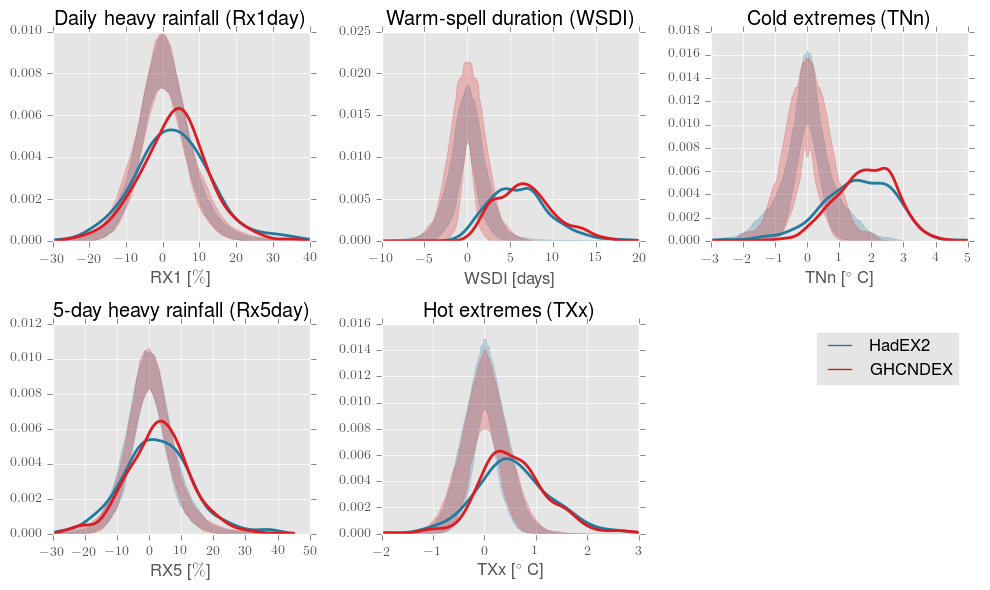

In [10]:
###########
# Plot Main
###########
f,pl=plt.subplots(nrows=2,ncols=3,figsize=(10,6))
pplot=pl.flatten()

region='global'
distro='pdf'



for varin,k in zip(varin_dict.keys(),range(len(pplot))):      
    for dataset in ['HadEX2','GHCNDEX']:
        pl5=varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][5]
        pl95=varoutdict[dataset][varin]._distributions[region][distro]['bs_quantiles'][95]
        pplot[k].fill_between(varoutdict[dataset][varin]._distributions[region][distro]['xaxis'],
                            pl95,pl5,color=colordict[dataset],
                                  alpha=0.25)
        
        pplot[k].plot(varoutdict[dataset][varin]._distributions[region][distro]['xaxis'],
                      varoutdict[dataset][varin]._distributions[region][distro]['Recent_ref'],
                      label=dataset,
                      color=colordict[dataset],
                      linewidth=2)
            
        pplot[k].set_title(varin_dict[varin]['longname'])
        pplot[k].set_xlabel(varin_dict[varin]['unit'])


            
pplot[5].axis('off')
for dataset in ['HadEX2','GHCNDEX']:pplot[5].plot(1,1,label=dataset,color=colordict[dataset])
pplot[5].legend(loc='upper right')

plt.tight_layout()
plt.show()

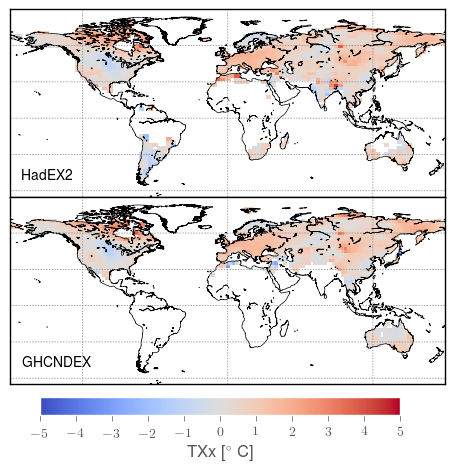

In [13]:
############
# Plot Diff Maps
############
varin='TXx'
fig,pl=plt.subplots(nrows=2,ncols=1,figsize=(6,5))
pplot=pl.flatten()
for dataset,k in zip(['HadEX2','GHCNDEX'],range(len(pplot))):
    tmp=varoutdict[dataset][varin]
    mask=tmp._masks['global']
    mask[np.isfinite(mask)]=1      
    diff=np.array(tmp._data_sliced['Recent'])*mask-np.array(tmp._data_sliced['ref'])*mask            
                
    im=varoutdict[dataset][varin].plot_map(to_plot=diff,
                                            ax=pplot[k],
                                            color_palette=plt.cm.coolwarm,
                                            color_range=[-5,5],
                                            color_bar=False,
                                            title='',
                                            show=False,
                                            limits=[-180,180,-65,90])
    pplot[k].text(-170,-50,dataset)

fig.subplots_adjust(bottom=0.15,wspace=0.0, hspace=0.0)
cbar_ax=fig.add_axes([0.2,0.05,0.6,0.5])
cbar_ax.axis('off')
cb=fig.colorbar(im,orientation='horizontal',label=varin_dict[varin]['unit'])
    
plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.show()


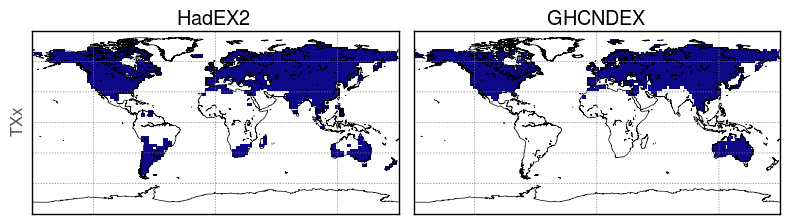

In [16]:
###########
# Plot Masks
###########
fig,pl=plt.subplots(nrows=1,ncols=2,figsize=(8,2.5))
pplot=pl.flatten()
k=0
for varin in ['TXx']:
    for dataset in ['HadEX2','GHCNDEX']:
        mask=varoutdict[dataset][varin]._masks['global'].copy()
        mask[np.isfinite(mask)]=1
        varoutdict[dataset][varin].plot_map(mask,
                                            ax=pplot[k],
                                            color_bar=False,
                                            show=False)
        if k<2:pplot[k].set_title(dataset)
        if (-1)**k>0:pplot[k].set_ylabel(varin)
        k+=1

plt.tight_layout()
plt.show()